# Pytorch开发深度学习模型一般步骤

## 1.定义DataSet
- 理解数据原始形式
- 理解数据编码方式
- 理解如何进行数据I/O

## 2.定义模型
- 定义各个子模块
- 将子模块合并成最终的模型

## 3.完成Train Pipeline/Valid Pipeline
- Pytorch一般的Train Pipeline/Valid Pipeline书写



In [42]:
import torch
from torch.utils.data import Dataset
import torch.utils.data as D
from torch import nn
import pandas as pd
import numpy as np
import copy
import os
from sklearn.metrics import roc_auc_score,log_loss
from tqdm import tqdm
from itertools import combinations

In [2]:
#参数配置

config = {
    "data_path":'criteo.csv',
    "sparse_cols":[f'C{x}' for x in range(1,27)],
    "dense_cols" : [f'I{x}' for x in range(1,14)],
    "train_ratio" : 0.7,
    "valid_ratio" : 0.2,
    "debug_mode" : True,
    "epoch" : 5,
    "batch" : 10240,
    "lr" : 0.0001,
    "device" : -1,
}

In [3]:
df = pd.read_csv(config['data_path'])

In [4]:
if config['debug_mode']:
    df = df[:1000]
df[config['sparse_cols']] = df[config['sparse_cols']].fillna('-1', )
df[config['dense_cols']] = df[config['dense_cols']].fillna(0, )
train_num = int(len(df)*config['train_ratio'])
valid_num = int(len(df)*config['valid_ratio'])
#切分数据集
train_df = df[:train_num].reset_index(drop=True)
valid_df = df[train_num:train_num+valid_num].reset_index(drop=True)
test_df = df[train_num+valid_num:].reset_index(drop=True)

## 1.定义DataSet
- 理解数据原始形式
- 理解数据编码方式
- 理解如何进行数据I/O




In [5]:
#Dataset构造
class BaseDataset(Dataset):
    def __init__(self,config,df,enc_dict=None):
        self.config = config
        self.df = df
        self.enc_dict = enc_dict
        self.dense_cols = list(set(self.config['dense_cols']))
        self.sparse_cols = list(set(self.config['sparse_cols']))
        self.feature_name = self.dense_cols+self.sparse_cols+['label']

        #数据编码
        if self.enc_dict == None:
            self.get_enc_dict()
        self.enc_data()

    def get_enc_dict(self):
        #计算enc_dict
        self.enc_dict = dict(zip( list(self.dense_cols+self.sparse_cols),[dict() for _ in range(len(self.dense_cols+self.sparse_cols))]))
        for f in self.sparse_cols:
            self.df[f] = self.df[f].astype('str')
            map_dict = dict(zip(self.df[f].unique(), range(1,self.df[f].nunique()+1)))
            self.enc_dict[f] = map_dict
            self.enc_dict[f]['vocab_size'] = self.df[f].nunique()+1
            '''
            eg:C17 特征的map_dict
            {'e5ba7672': 1,
             '07c540c4': 2,
             '8efede7f': 3,
             '1e88c74f': 4,
             '776ce399': 5,
             'd4bb7bd8': 6,
             '3486227d': 7,
             '27c07bd6': 8,
             '2005abd1': 9,
             'vocab_size': 10}
            '''

        for f in self.dense_cols:
            self.enc_dict[f]['min'] = self.df[f].min()
            self.enc_dict[f]['max'] = self.df[f].max()
            '''
            eg:I6 特征
            {'min': 0.0, 'max': 4638.0}
            '''
        return self.enc_dict

    def enc_dense_data(self,col):
        return (self.df[col] - self.enc_dict[col]['min']) / (self.enc_dict[col]['max'] - self.enc_dict[col]['min'])

    def enc_sparse_data(self,col):
        return self.df[col].apply(lambda x : self.enc_dict[col].get(x,0))

    def enc_data(self):
        #使用enc_dict对数据进行编码
        self.enc_df = copy.deepcopy(self.df)
        for col in self.dense_cols:
            self.enc_df[col] = self.enc_dense_data(col)
        for col in self.sparse_cols:
            self.enc_df[col] = self.enc_sparse_data(col)

    def __getitem__(self, index):
        data = dict()
        for col in self.feature_name:
            if col in self.dense_cols:
                data[col] = torch.Tensor([self.enc_df[col].iloc[index]]).squeeze(-1)
            elif col in self.sparse_cols:
                data[col] = torch.Tensor([self.enc_df[col].iloc[index]]).long().squeeze(-1)
        data['label'] = torch.Tensor([self.enc_df['label'].iloc[index]]).squeeze(-1)
        return data

    def __len__(self):
        return len(self.enc_df)

In [6]:
train_dataset = BaseDataset(config,train_df)
enc_dict = train_dataset.get_enc_dict()

valid_dataset = BaseDataset(config,valid_df,enc_dict=enc_dict)
test_dataset = BaseDataset(config,test_df,enc_dict=enc_dict)

In [7]:
train_dataset.__getitem__(5)

{'I11': tensor(0.),
 'I12': tensor(0.),
 'I1': tensor(0.),
 'I6': tensor(0.),
 'I5': tensor(0.0144),
 'I2': tensor(0.),
 'I9': tensor(0.0011),
 'I10': tensor(0.),
 'I4': tensor(0.),
 'I13': tensor(0.),
 'I3': tensor(0.),
 'I7': tensor(0.),
 'I8': tensor(0.),
 'C2': tensor(6),
 'C9': tensor(1),
 'C16': tensor(6),
 'C14': tensor(3),
 'C25': tensor(2),
 'C3': tensor(6),
 'C8': tensor(2),
 'C22': tensor(3),
 'C26': tensor(3),
 'C19': tensor(2),
 'C5': tensor(2),
 'C11': tensor(6),
 'C4': tensor(6),
 'C21': tensor(6),
 'C18': tensor(6),
 'C15': tensor(6),
 'C20': tensor(3),
 'C7': tensor(6),
 'C24': tensor(6),
 'C12': tensor(6),
 'C6': tensor(4),
 'C23': tensor(3),
 'C13': tensor(6),
 'C10': tensor(3),
 'C17': tensor(5),
 'C1': tensor(4),
 'label': tensor(0.)}

## 2.定义模型
- 定义各个子模块
- 将子模块合并成最终的模型

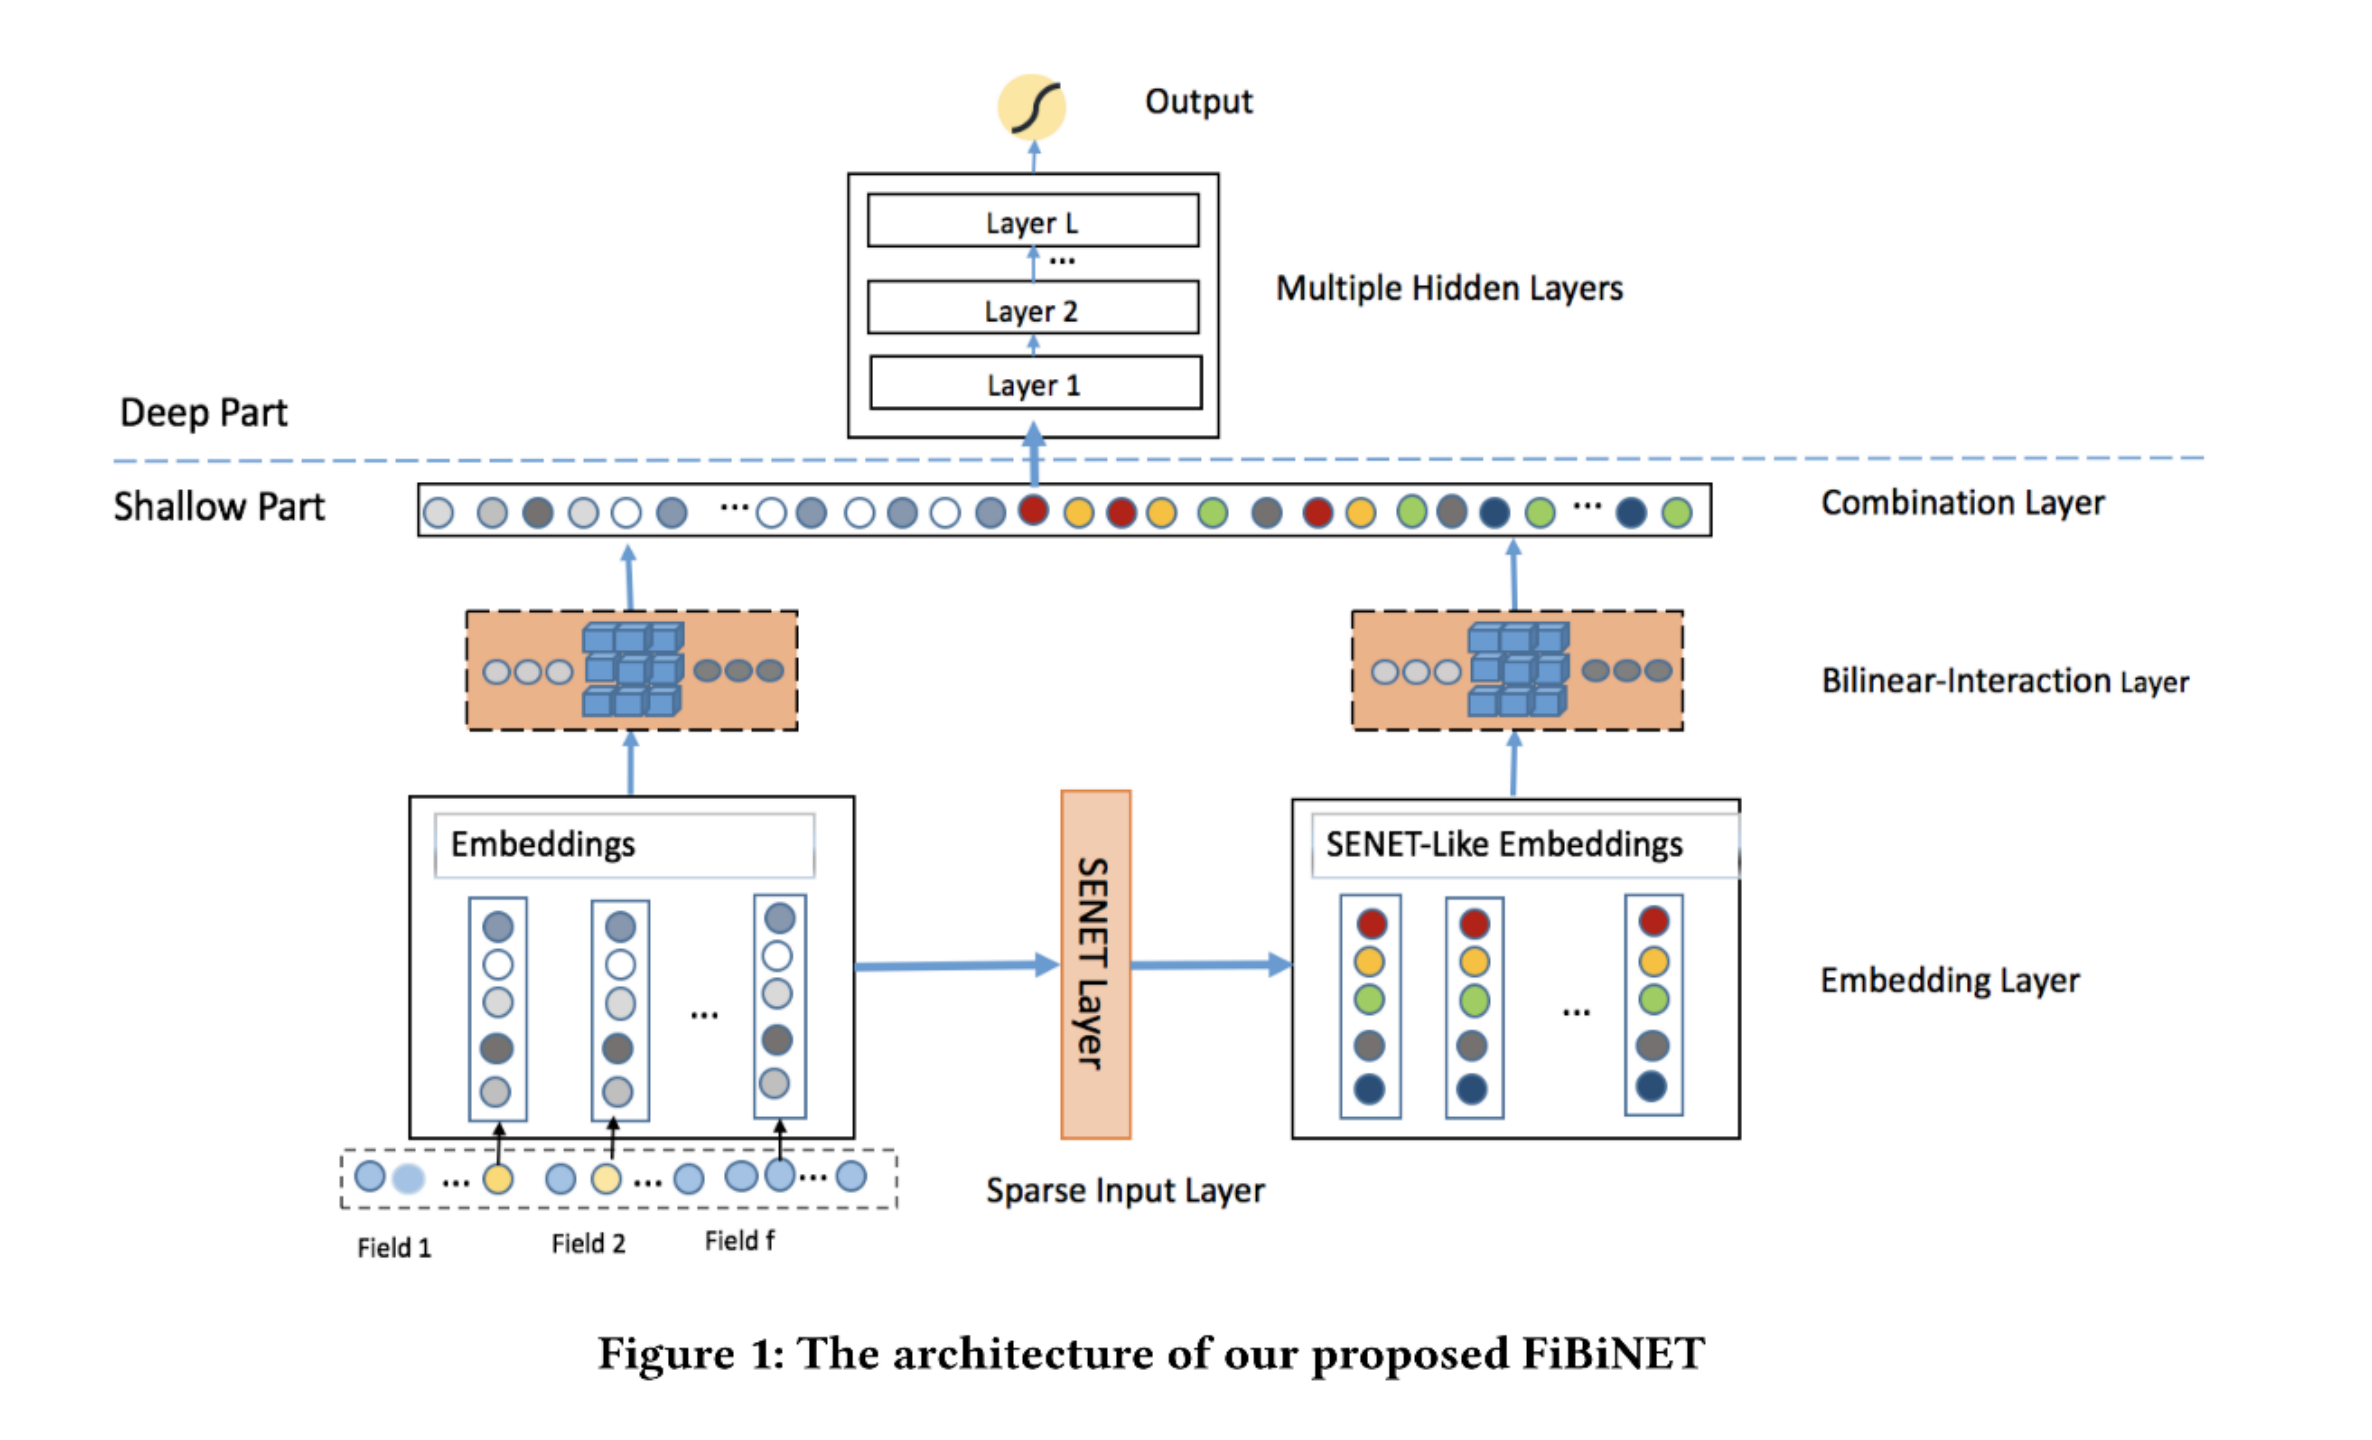

In [29]:
#基本网络模块

#通用Emb
class EmbeddingLayer(nn.Module):
    def __init__(self,
                 enc_dict = None,
                 embedding_dim = None):
        super(EmbeddingLayer, self).__init__()
        self.enc_dict = enc_dict
        self.embedding_dim = embedding_dim
        self.embedding_layer = nn.ModuleDict()

        self.emb_feature = []

        for col in self.enc_dict.keys():
            if 'vocab_size' in self.enc_dict[col].keys():
                self.emb_feature.append(col)
                self.embedding_layer.update({col : nn.Embedding(
                    self.enc_dict[col]['vocab_size'],
                    self.embedding_dim,
                )})

    def forward(self, X):
        #对所有的sparse特征挨个进行embedding
        feature_emb_list = []
        for col in self.emb_feature:
            inp = X[col].long().view(-1, 1)
            feature_emb_list.append(self.embedding_layer[col](inp))
        return feature_emb_list
    
#一阶交叉
class LR_Layer(nn.Module):
    def __init__(self,enc_dict):
        super(LR_Layer, self).__init__()
        self.enc_dict = enc_dict
        self.emb_layer = EmbeddingLayer(enc_dict=self.enc_dict,embedding_dim=1)
        self.dnn_input_dim = get_dnn_input_dim(self.enc_dict, 1)
        self.fc = nn.Linear(self.dnn_input_dim,1)
        
    def forward(self,data):
        sparse_emb = self.emb_layer(data)
        sparse_emb = torch.stack(sparse_emb,dim=1).flatten(1) #[batch,num_sparse*emb]
        dense_input = get_linear_input(self.enc_dict, data)  #[batch,num_dense]
        dnn_input = torch.cat((sparse_emb, dense_input), dim=1) # [batch,num_sparse*emb + num_dense]
        out = self.fc(dnn_input)
        return out
    

## SENET
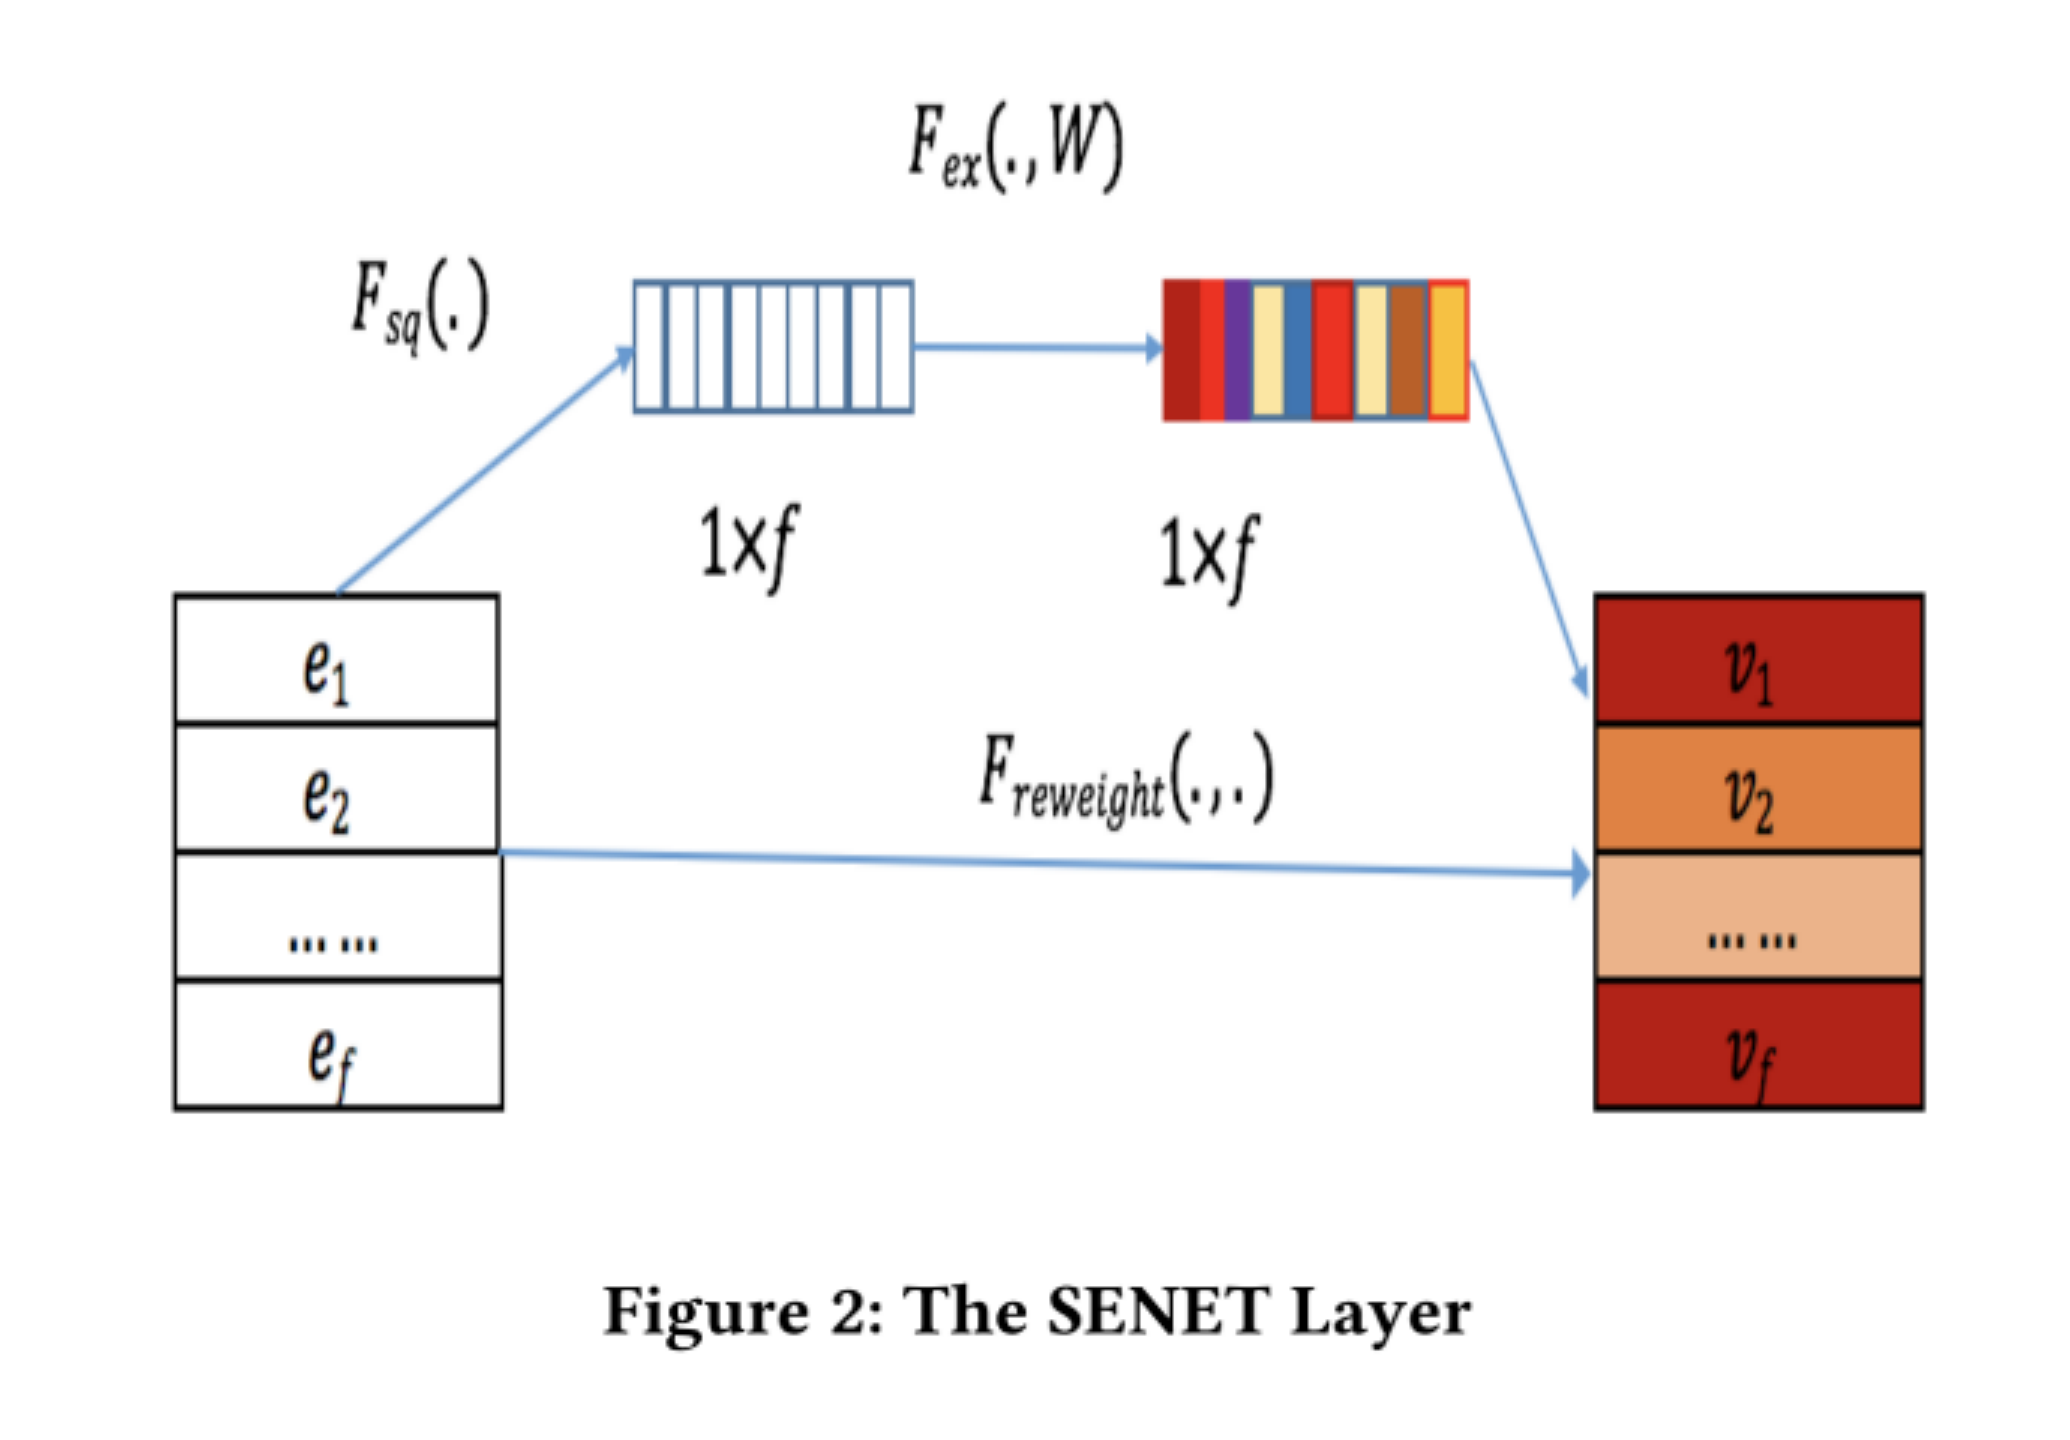

In [150]:
class SENET_Layer(nn.Module):
    def __init__(self, num_fields, reduction_ratio=3):
        super(SENET_Layer, self).__init__()
        reduced_size = max(1, int(num_fields / reduction_ratio))
        self.excitation = nn.Sequential(nn.Linear(num_fields, reduced_size, bias=False),
                                        nn.ReLU(),
                                        nn.Linear(reduced_size, num_fields, bias=False),
                                        nn.ReLU())

    def forward(self, feature_emb):
        assert len(feature_emb.shape) == 3, "Unexpected inputs dimensions %d, expect to be 3 dimensions" % (len(feature_emb.shape))
        Z = torch.mean(feature_emb, dim=-1, out=None) # [batch, f, embedding_dim] -> [batch, f]
        A = self.excitation(Z) # Z:[batch, f] -> 中间变量:[batch, reduced_size] -> A:[batch, f]
        V = feature_emb * A.unsqueeze(-1) # feature_emb:[batch, f, embedding_dim] A.unsqueeze(-1):[batch, f, 1]
        return V,A

In [151]:
'''
三种类型的Bilinear-Interaction

eg：两个向量A和B做Bilinear-Intearaction （*代表矩阵乘法，x代表哈达玛积）
out = A*WxB
分析：
out1 = A*W -> nn.Linear(embedding_dim, embedding_dim, bias=False)(A)
out = out1 x B -> nn.Linear(embedding_dim, embedding_dim, bias=False)(A) * B
'''
class BilinearInteractionLayer(nn.Module):
    def __init__(self, num_fields, embedding_dim, bilinear_type="field_interaction"):
        super(BilinearInteractionLayer, self).__init__()
        self.bilinear_type = bilinear_type
        
        assert self.bilinear_type in ['all','each','interaction'], "Unexpected bilinear_type %d, expect to be in ['field_all','field_each','field_interaction'] " % (self.bilinear_type)
        
        if self.bilinear_type == "field_all":
            self.bilinear_layer = nn.Linear(embedding_dim, embedding_dim, bias=False)
        elif self.bilinear_type == "field_each":
            self.bilinear_layer = nn.ModuleList([nn.Linear(embedding_dim, embedding_dim, bias=False)
                                                 for i in range(num_fields)])
        elif self.bilinear_type == "field_interaction":
            self.bilinear_layer = nn.ModuleList([nn.Linear(embedding_dim, embedding_dim, bias=False)
                                                 for i, j in combinations(range(num_fields), 2)])

    def forward(self, feature_emb):
        # feature_emb : [batch, num_fileds, embedding_dim]
        assert len(feature_emb.shape) == 3, "Unexpected inputs dimensions %d, expect to be 3 dimensions" % (len(feature_emb.shape))
        feature_emb_list = torch.split(feature_emb, 1, dim=1)
        if self.bilinear_type == "field_all":
            bilinear_list = [self.bilinear_layer(v_i) * v_j
                             for v_i, v_j in combinations(feature_emb_list, 2)]
        elif self.bilinear_type == "field_each":
            bilinear_list = [self.bilinear_layer[i](feature_emb_list[i]) * feature_emb_list[j]
                             for i, j in combinations(range(len(feature_emb_list)), 2)]
        elif self.bilinear_type == "field_interaction":
            bilinear_list = [self.bilinear_layer[i](v[0]) * v[1]
                             for i, v in enumerate(combinations(feature_emb_list, 2))]
        return torch.cat(bilinear_list, dim=1)

In [152]:
for idx,v in enumerate(combinations([1,2,3,4], 2)):
    print(idx,v)

0 (1, 2)
1 (1, 3)
2 (1, 4)
3 (2, 3)
4 (2, 4)
5 (3, 4)


In [161]:
for q,w in zip([1,2,3,4],[6,7,8,9]):
    print(q,w)

1 6
2 7
3 8
4 9


In [153]:
#DNN
class MLP_Layer(nn.Module):
    def __init__(self,
                 input_dim,
                 output_dim=None,
                 hidden_units=[],
                 hidden_activations="ReLU",
                 final_activation=None,
                 dropout_rates=0,
                 batch_norm=False,
                 use_bias=True):
        super(MLP_Layer, self).__init__()
        dense_layers = []
        if not isinstance(dropout_rates, list):
            dropout_rates = [dropout_rates] * len(hidden_units)
        if not isinstance(hidden_activations, list):
            hidden_activations = [hidden_activations] * len(hidden_units)
        hidden_activations = [set_activation(x) for x in hidden_activations]
        hidden_units = [input_dim] + hidden_units
        for idx in range(len(hidden_units) - 1):
            dense_layers.append(nn.Linear(hidden_units[idx], hidden_units[idx + 1], bias=use_bias))
            if batch_norm:
                dense_layers.append(nn.BatchNorm1d(hidden_units[idx + 1]))
            if hidden_activations[idx]:
                dense_layers.append(hidden_activations[idx])
            if dropout_rates[idx] > 0:
                dense_layers.append(nn.Dropout(p=dropout_rates[idx]))
        if output_dim is not None:
            dense_layers.append(nn.Linear(hidden_units[-1], output_dim, bias=use_bias))
        if final_activation is not None:
            dense_layers.append(set_activation(final_activation))
        self.dnn = nn.Sequential(*dense_layers)  # * used to unpack list

    def forward(self, inputs):
        return self.dnn(inputs)

def set_device(gpu=-1):
    if gpu >= 0 and torch.cuda.is_available():
        os.environ["CUDA_VISIBLE_DEVICES"] = str(gpu)
        device = torch.device(f"cuda:{gpu}")
    else:
        device = torch.device("cpu")
    return device
    
def set_activation(activation):
    if isinstance(activation, str):
        if activation.lower() == "relu":
            return nn.ReLU()
        elif activation.lower() == "sigmoid":
            return nn.Sigmoid()
        elif activation.lower() == "tanh":
            return nn.Tanh()
        else:
            return getattr(nn, activation)()
    else:
        return activation
    
def get_feature_num(enc_dict):
    num_sparse = 0
    num_dense = 0
    for col in enc_dict.keys():
        if 'min' in enc_dict[col].keys():
            num_dense+=1
        elif 'vocab_size' in enc_dict[col].keys():
            num_sparse+=1
    return num_sparse,num_dense
    
def get_dnn_input_dim(enc_dict,embedding_dim):
    num_sparse = 0
    num_dense = 0
    for col in enc_dict.keys():
        if 'min' in enc_dict[col].keys():
            num_dense+=1
        elif 'vocab_size' in enc_dict[col].keys():
            num_sparse+=1
    return num_sparse*embedding_dim+num_dense

def get_linear_input(enc_dict,data):
    res_data = []
    for col in enc_dict.keys():
        if 'min' in enc_dict[col].keys():
            res_data.append(data[col])
    res_data = torch.stack(res_data,axis=1)
    return res_data

In [154]:
#FiBiNET
class FiBiNET(nn.Module):
    def __init__(self,
                 embedding_dim=32,
                 hidden_units=[64, 64, 64],
                 reduction_ratio = 3,
                 bilinear_type='field_interaction',
                 loss_fun = 'torch.nn.BCELoss()',
                 enc_dict=None):
        super(FiBiNET, self).__init__()

        self.embedding_dim = embedding_dim
        self.hidden_units = hidden_units
        self.reduction_ratio = reduction_ratio
        self.bilinear_type = bilinear_type
        self.loss_fun = eval(loss_fun)
        self.enc_dict = enc_dict

        self.embedding_layer = EmbeddingLayer(enc_dict=self.enc_dict, embedding_dim=self.embedding_dim)
        num_sparse,num_dense = get_feature_num(self.enc_dict)
        
        self.senet = SENET_Layer(num_fields=num_sparse)
        self.bilinear = BilinearInteractionLayer(num_fields=num_sparse,
                                                embedding_dim=self.embedding_dim,
                                                bilinear_type=self.bilinear_type)
        self.lr = LR_Layer(enc_dict=enc_dict) #一阶

        # (n-1)*n /2 * embedding_dim + (n-1)*n /2 * embedding_dim + num_dense
        self.dnn_input_dim = num_sparse*(num_sparse-1)*self.embedding_dim + num_dense
        #sparse_num * emb_dim + dense_num

        self.dnn = MLP_Layer(input_dim=self.dnn_input_dim, output_dim=1, hidden_units=self.hidden_units,
                                 hidden_activations='relu', dropout_rates=0)
    
    def get_senet_weights(self, data):
        sparse_embedding = self.embedding_layer(data)
        sparse_embedding = torch.stack(sparse_embedding,1).squeeze(2)
        
        _,A = self.senet(sparse_embedding)
        return A.detach().cpu().numpy()
        
        
    def forward(self, data):
        sparse_embedding = self.embedding_layer(data)
        sparse_embedding = torch.stack(sparse_embedding,1).squeeze(2) #[batch,num_sparse,embedding_dim]
        dense_input = get_linear_input(self.enc_dict, data)
        
        lr_logit = self.lr(data)
        
        # SENET
        senet_embedding,_ = self.senet(sparse_embedding)
        
        #Bilinear-Interaction
        p = self.bilinear(sparse_embedding) #[batch, (n-1)*n/2 ,embedding_dim] 
        q = self.bilinear(senet_embedding)  #[batch, (n-1)*n/2 ,embedding_dim]
        
        # Combination Layer
        c = torch.flatten(torch.cat([p,q],dim=1),start_dim=1) #[batch, (n-1)*n/2 ,embedding_dim] -> [batch, (n-1)*n/2 * embedding_dim]
        dnn_input = torch.cat((c, dense_input), dim=1) # [batch, dnn_input_dim]
        # DNN
        dnn_logit = self.dnn(dnn_input)
        
        #输出
        y_pred = torch.sigmoid(lr_logit + dnn_logit)
        loss = self.loss_fun(y_pred.squeeze(-1),data['label'])
        output_dict = {'pred':y_pred,'loss':loss}
        return output_dict

## 3.完成Train Pipeline/Valid Pipeline
- Pytorch一般的Train Pipeline/Valid Pipeline书写

In [155]:
#训练模型，验证模型
def train_model(model, train_loader, optimizer, device, metric_list=['roc_auc_score','log_loss']):
    model.train()
    pred_list = []
    label_list = []
    pbar = tqdm(train_loader)
    for data in pbar:

        for key in data.keys():
            data[key] = data[key].to(device)

        output = model(data)
        pred = output['pred']
        loss = output['loss']

        loss.backward()
        optimizer.step()
        model.zero_grad()

        pred_list.extend(pred.squeeze(-1).cpu().detach().numpy())
        label_list.extend(data['label'].squeeze(-1).cpu().detach().numpy())
        pbar.set_description("Loss {}".format(loss))

    res_dict = dict()
    for metric in metric_list:
        if metric =='log_loss':
            res_dict[metric] = log_loss(label_list,pred_list, eps=1e-7)
        else:
            res_dict[metric] = eval(metric)(label_list,pred_list)

    return res_dict

def valid_model(model, valid_loader, device, metric_list=['roc_auc_score','log_loss']):
    model.eval()
    pred_list = []
    label_list = []

    for data in (valid_loader):

        for key in data.keys():
            data[key] = data[key].to(device)

        output = model(data)
        pred = output['pred']

        pred_list.extend(pred.squeeze(-1).cpu().detach().numpy())
        label_list.extend(data['label'].squeeze(-1).cpu().detach().numpy())

    res_dict = dict()
    for metric in metric_list:
        if metric =='log_loss':
            res_dict[metric] = log_loss(label_list,pred_list, eps=1e-7)
        else:
            res_dict[metric] = eval(metric)(label_list,pred_list)

    return res_dict

def test_model(model, test_loader, device, metric_list=['roc_auc_score','log_loss']):
    model.eval()
    pred_list = []
    label_list = []

    for data in (test_loader):

        for key in data.keys():
            data[key] = data[key].to(device)

        output = model(data)
        pred = output['pred']

        pred_list.extend(pred.squeeze().cpu().detach().numpy())
        label_list.extend(data['label'].squeeze().cpu().detach().numpy())

    res_dict = dict()
    for metric in metric_list:
        if metric =='log_loss':
            res_dict[metric] = log_loss(label_list,pred_list, eps=1e-7)
        else:
            res_dict[metric] = eval(metric)(label_list,pred_list)

    return res_dict

In [156]:
#dataloader
train_loader = D.DataLoader(train_dataset,batch_size=config['batch'],shuffle=True,num_workers=0)
valid_loader = D.DataLoader(valid_dataset,batch_size=config['batch'],shuffle=False,num_workers=0)
test_loader = D.DataLoader(test_dataset,batch_size=config['batch'],shuffle=False,num_workers=0)

In [157]:
model = FiBiNET(enc_dict=enc_dict)

In [158]:
device = set_device(config['device'])
optimizer = torch.optim.Adam(model.parameters(), lr=config['lr'], betas=(0.9, 0.999), eps=1e-08, weight_decay=0)
model = model.to(device)
#模型训练流程
for i in range(config['epoch']):
    #模型训练
    train_metirc = train_model(model,train_loader,optimizer=optimizer,device=device)
    #模型验证
    valid_metric = valid_model(model,valid_loader,device)

    print("Train Metric:")
    print(train_metirc)
    print("Valid Metric:")
    print(valid_metric)
#测试模型
test_metric = test_model(model,test_loader,device)
print('Test Metric:')
print(test_metric)

Loss 0.735206127166748: 100%|█████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.46it/s]


Train Metric:
{'roc_auc_score': 0.42107443723242655, 'log_loss': 0.7352061327653272}
Valid Metric:
{'roc_auc_score': 0.47450553438577386, 'log_loss': 0.7385082991421222}


Loss 0.727992832660675: 100%|█████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.48it/s]


Train Metric:
{'roc_auc_score': 0.4279795608341389, 'log_loss': 0.7279928881355694}
Valid Metric:
{'roc_auc_score': 0.47359825802939576, 'log_loss': 0.733516094237566}


Loss 0.7213321924209595: 100%|████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.34s/it]


Train Metric:
{'roc_auc_score': 0.4344201579390089, 'log_loss': 0.7213321833525386}
Valid Metric:
{'roc_auc_score': 0.47450553438577386, 'log_loss': 0.7283881528675556}


Loss 0.7149660587310791: 100%|████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.44it/s]


Train Metric:
{'roc_auc_score': 0.4400572497520433, 'log_loss': 0.7149660352723939}
Valid Metric:
{'roc_auc_score': 0.47559426601342775, 'log_loss': 0.7230175614356995}


Loss 0.7085721492767334: 100%|████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.44it/s]


Train Metric:
{'roc_auc_score': 0.44589521788803654, 'log_loss': 0.7085721688611167}
Valid Metric:
{'roc_auc_score': 0.47468698965704953, 'log_loss': 0.7174261678755284}
Test Metric:
{'roc_auc_score': 0.4817872753763963, 'log_loss': 0.706930882036686}


# Case Study

In [159]:
case_data = next(iter(test_loader))

In [135]:
case_data

{'I11': tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0625, 0.1562, 0.0625, 0.0312, 0.0000,
         0.0312, 0.0000, 0.0312, 0.1875, 0.0000, 0.1250, 0.1250, 0.0000, 0.0625,
         0.0000, 0.0938, 0.0625, 0.0312, 0.0625, 0.0000, 0.5312, 0.0000, 0.0000,
         0.0000, 0.0625, 0.0312, 0.0000, 0.0312, 0.0000, 0.0000, 0.0312, 0.0000,
         0.0312, 0.0000, 0.6875, 0.0938, 0.0312, 0.0312, 0.0000, 0.0312, 0.0312,
         0.0312, 0.0625, 0.0938, 0.0938, 0.0000, 0.0000, 0.0312, 0.1875, 0.1250,
         0.0000, 0.0312, 0.0000, 0.0312, 0.0625, 0.3438, 0.0312, 0.3125, 0.0625,
         0.0312, 0.0938, 0.0312, 0.0312, 0.0625, 0.0625, 0.1250, 0.0000, 0.0000,
         0.1250, 0.0312, 0.0000, 0.0938, 0.0312, 0.0312, 0.0625, 0.0000, 0.0000,
         0.0312, 0.0312, 0.0000, 0.0000, 0.0312, 0.0312, 0.0000, 0.0625, 0.0000,
         0.0312, 0.0000, 0.0312, 0.0625, 0.0312, 0.0000, 0.0938, 0.0312, 0.0938,
         0.0000]),
 'I12': tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0

In [136]:
senet_weights = model.get_senet_weights(case_data)

In [138]:
senet_weights.shape

(100, 26)

In [139]:
weights_df = pd.DataFrame(senet_weights,columns=[f'I{x}_weight' for x in range(1,27)])

In [140]:
pd.set_option ('display.max_columns',500)
weights_df.describe()

,I1_weight,I2_weight,I3_weight,I4_weight,I5_weight,I6_weight,I7_weight,I8_weight,I9_weight,I10_weight,I11_weight,I12_weight,I13_weight,I14_weight,I15_weight,I16_weight,I17_weight,I18_weight,I19_weight,I20_weight,I21_weight,I22_weight,I23_weight,I24_weight,I25_weight,I26_weight
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,0.028057,0.001947,0.003374,0.020693,0.002298,0.018163,0.003593,0.006258,0.035766,0.049068,0.004038,0.017591,0.046511,0.026249,0.001892,0.026108,0.016639,0.018066,0.013813,0.002316,0.005411,0.015958,0.042282,0.006259,0.043376,0.000507
std,0.017633,0.007150,0.009182,0.021569,0.007907,0.015919,0.007470,0.013375,0.024998,0.034052,0.008702,0.019190,0.030065,0.025676,0.004616,0.021486,0.019923,0.018987,0.017367,0.005177,0.009517,0.016457,0.027684,0.011235,0.029967,0.001603
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.001643,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.016284,0.000000,0.000000,0.001640,0.000000,0.003894,0.000000,0.000000,0.018128,0.027655,0.000000,0.000000,0.025995,0.001133,0.000000,0.009171,0.000000,0.001036,0.000000,0.000000,0.000000,0.000000,0.025025,0.000000,0.022409,0.000000
50%,0.027025,0.000000,0.000000,0.015044,0.000000,0.015672,0.000000,0.000000,0.030521,0.043880,0.000000,0.012367,0.042744,0.021623,0.000000,0.020902,0.008672,0.011014,0.006769,0.000000,0.000000,0.011585,0.036285,0.000000,0.036052,0.000000
75%,0.038843,0.000000,0.000000,0.031636,0.000000,0.027693,0.004565,0.005733,0.048254,0.069533,0.004034,0.027136,0.061427,0.041053,0.000570,0.037403,0.027037,0.028406,0.025354,0.001406,0.007480,0.025813,0.052582,0.007502,0.061492,0.000000
max,0.082606,0.047566,0.049372,0.102388,0.063218,0.057321,0.041757,0.066220,0.110629,0.146967,0.045657,0.076648,0.136878,0.113492,0.022188,0.080715,0.080104,0.070581,0.078335,0.027335,0.041148,0.075874,0.141876,0.052111,0.141879,0.009167


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

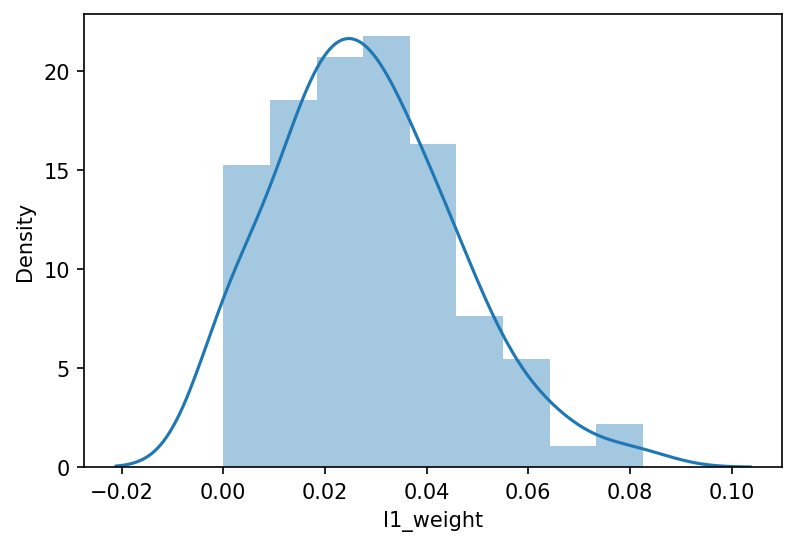

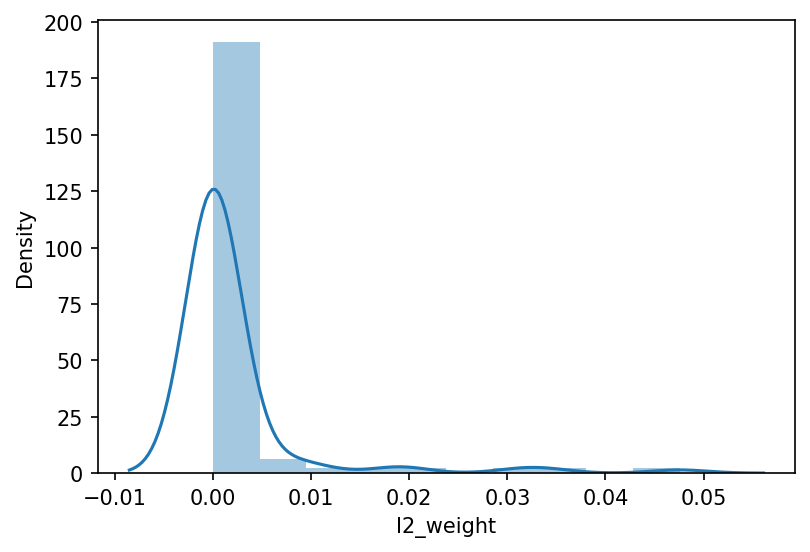

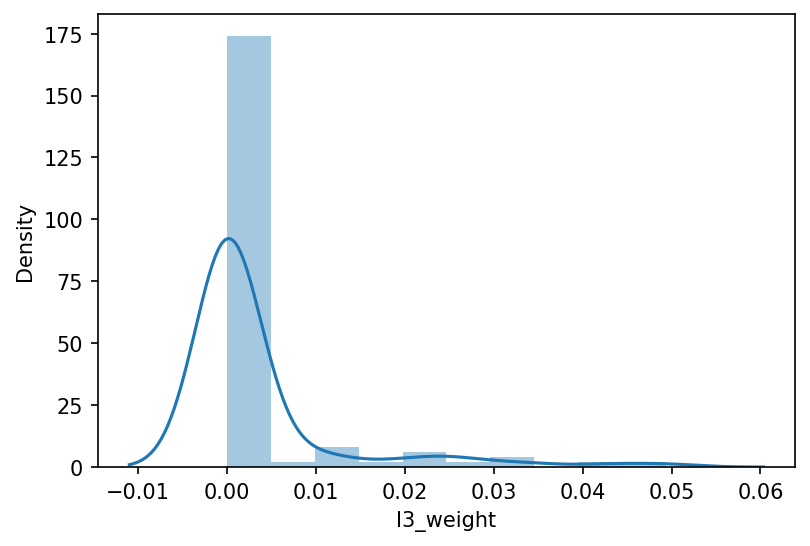

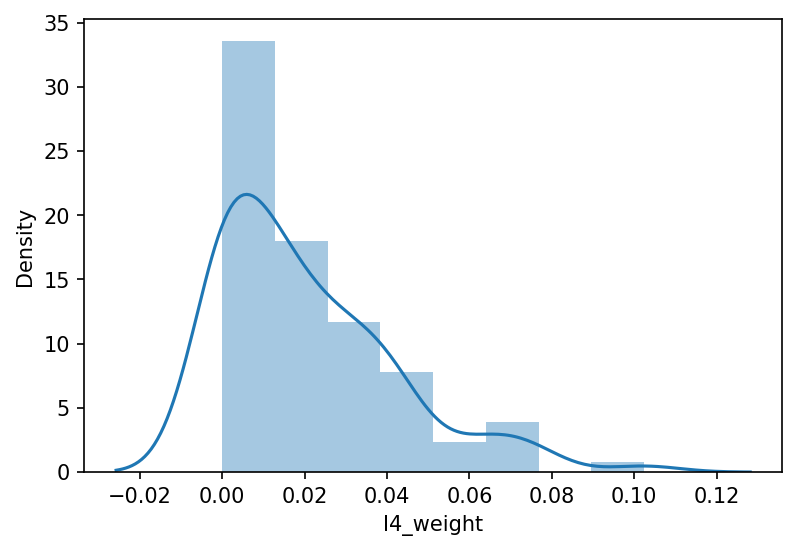

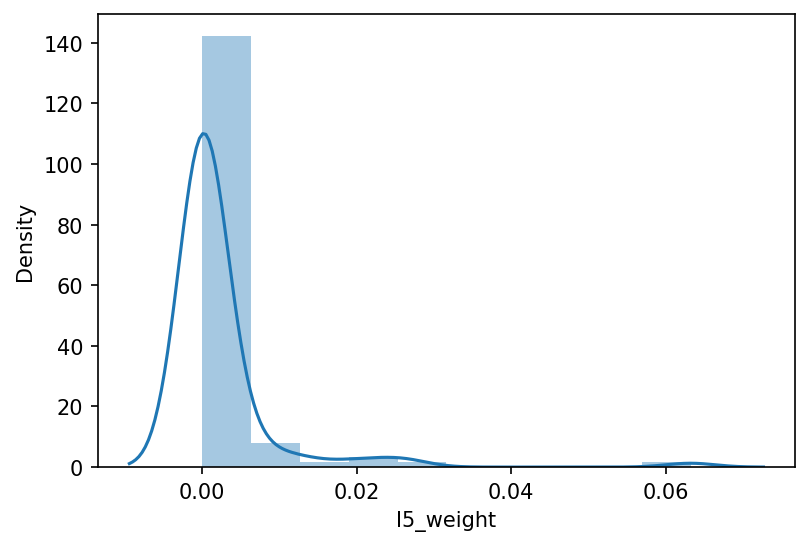

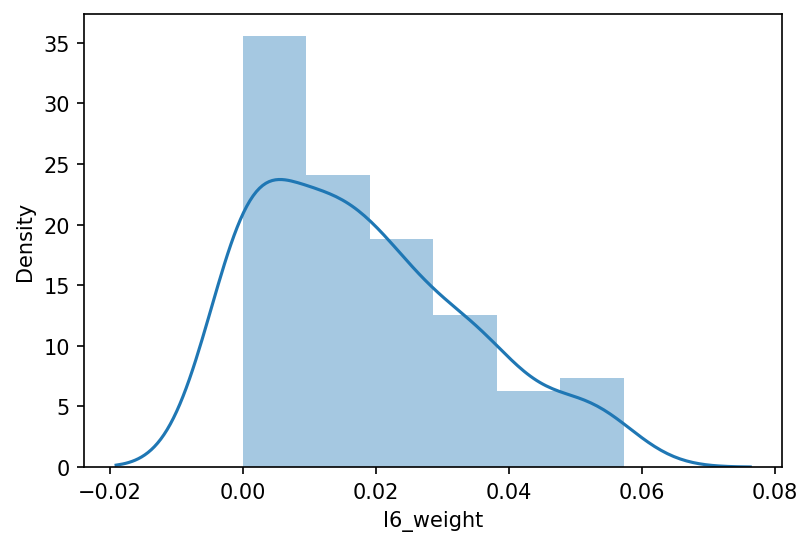

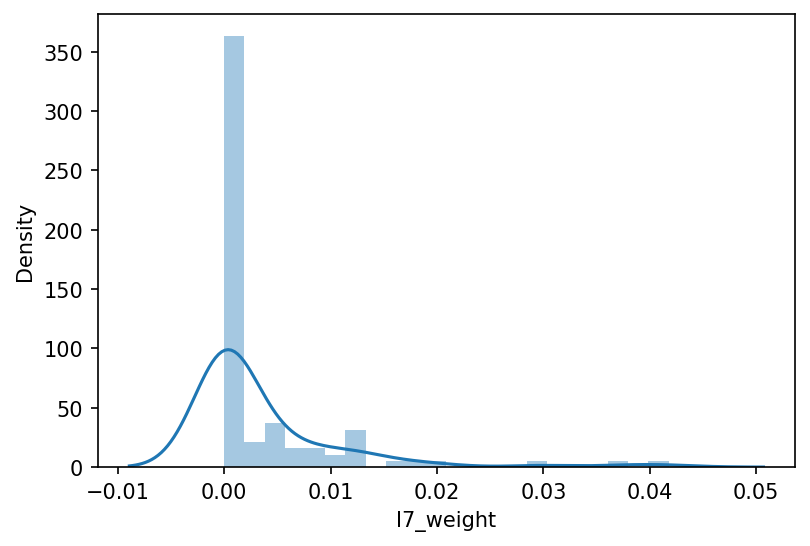

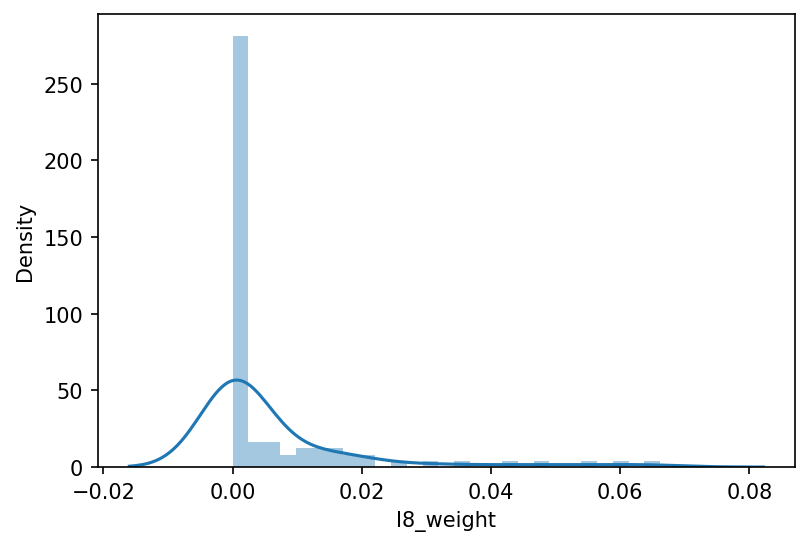

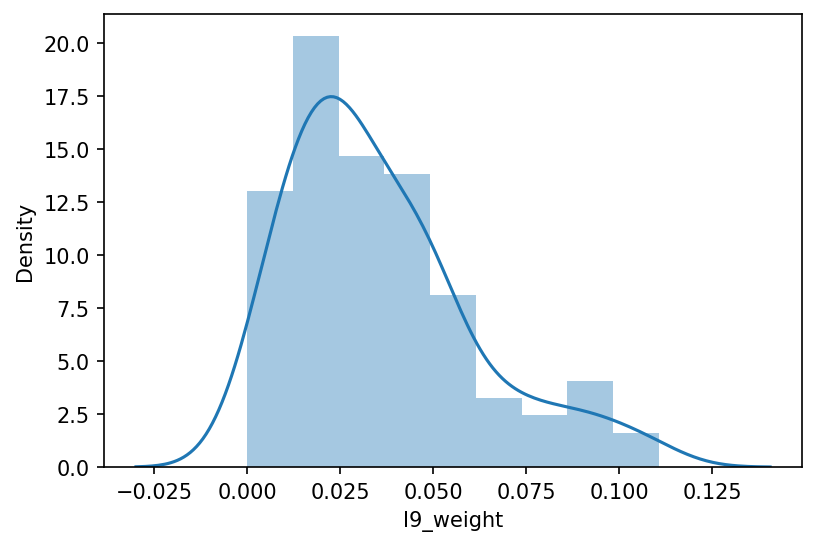

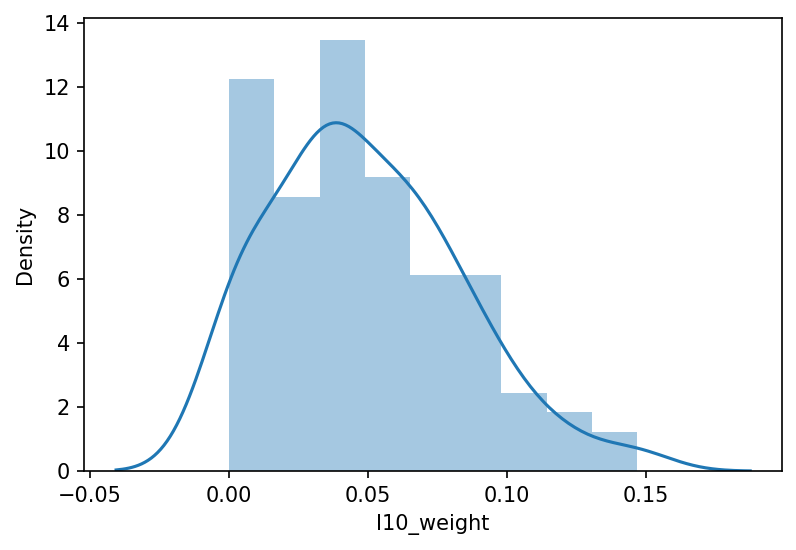

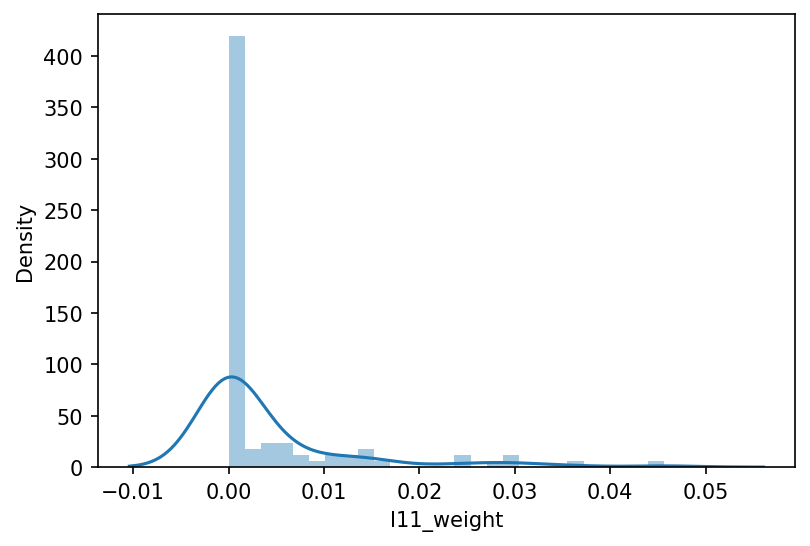

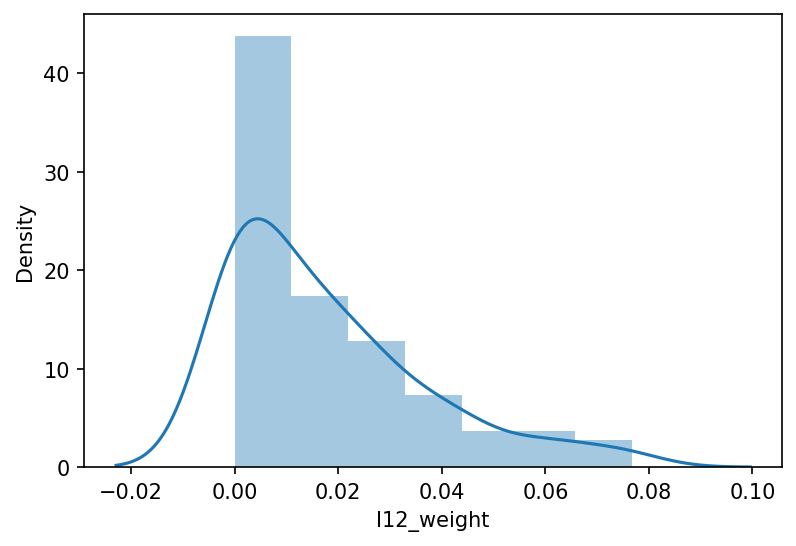

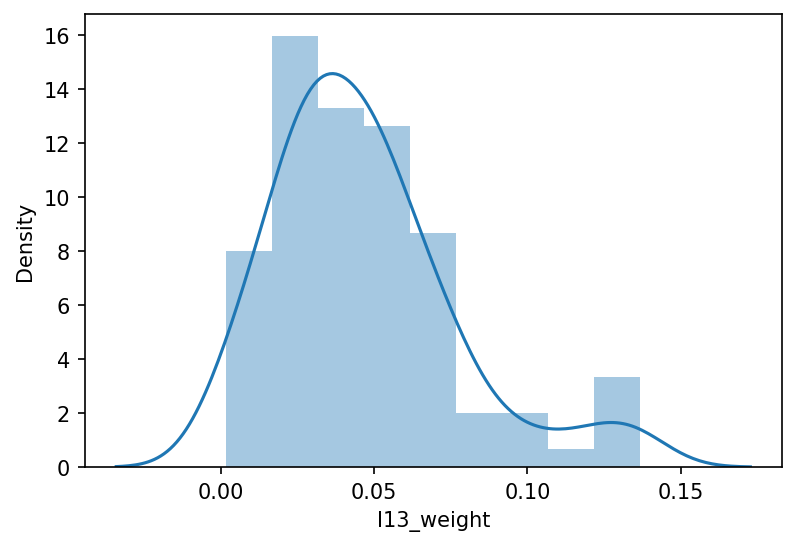

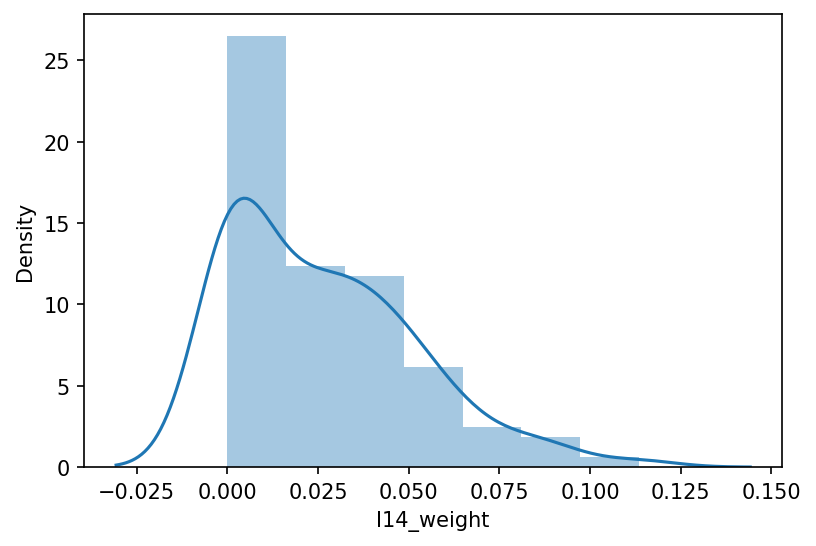

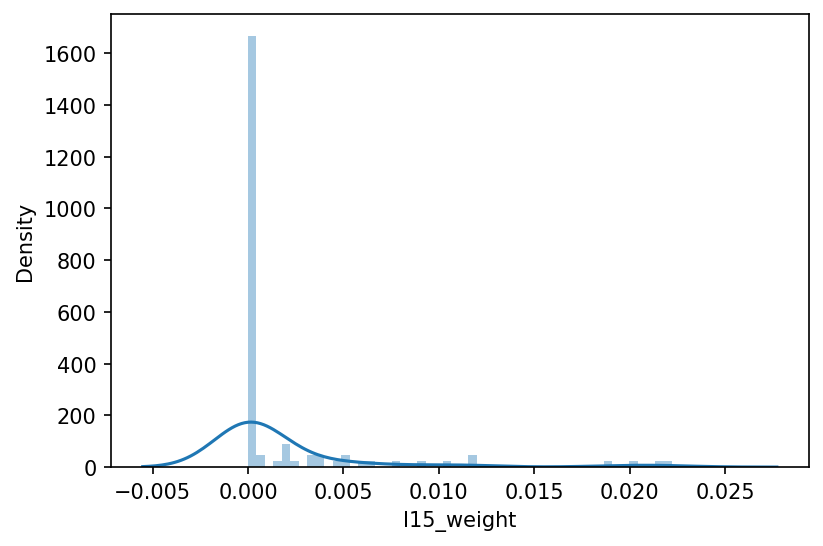

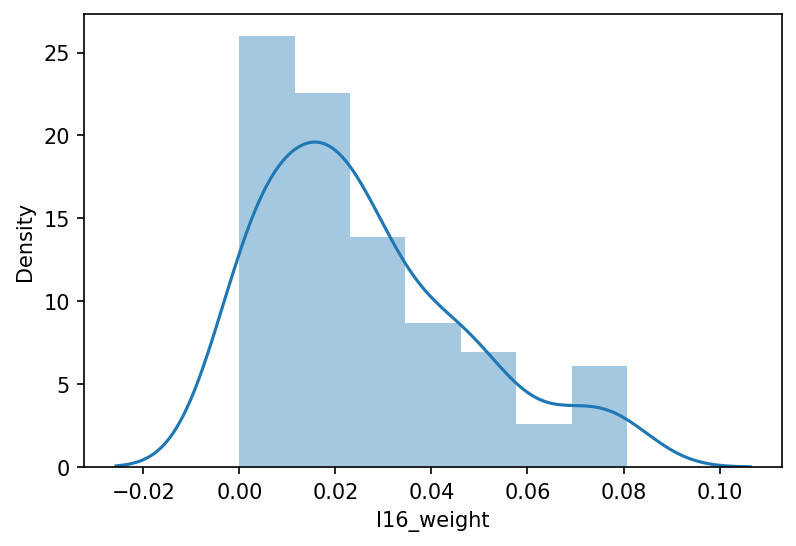

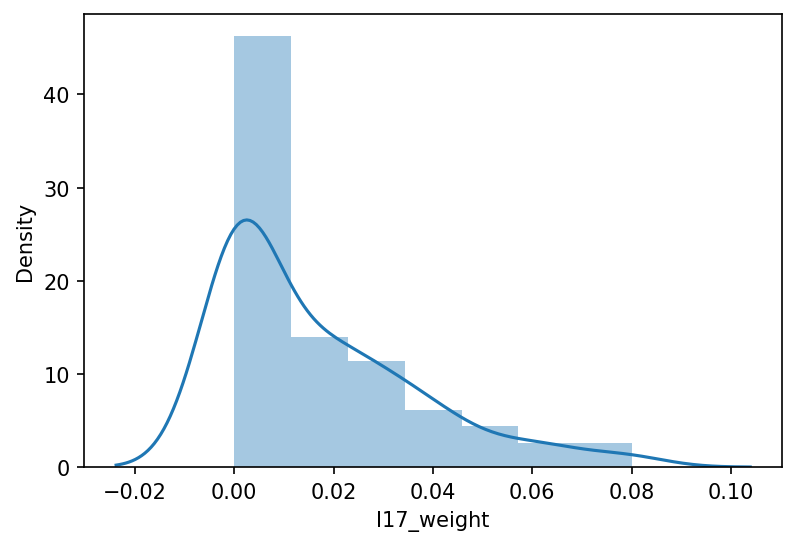

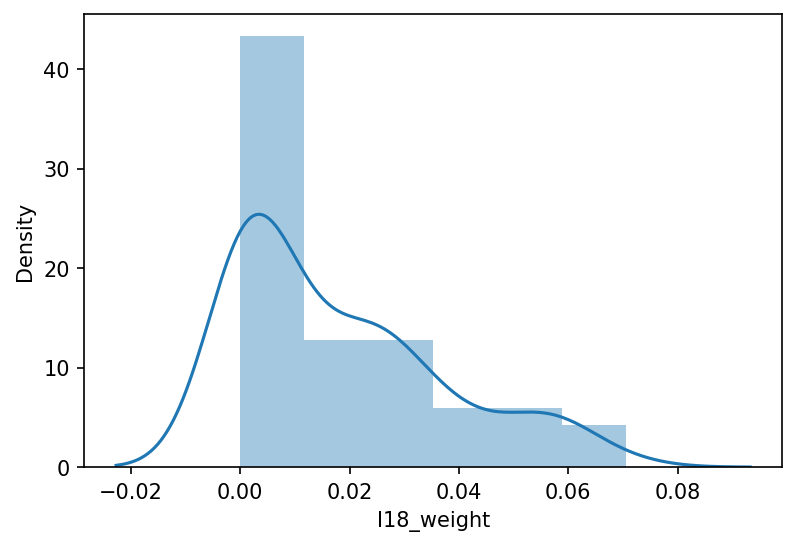

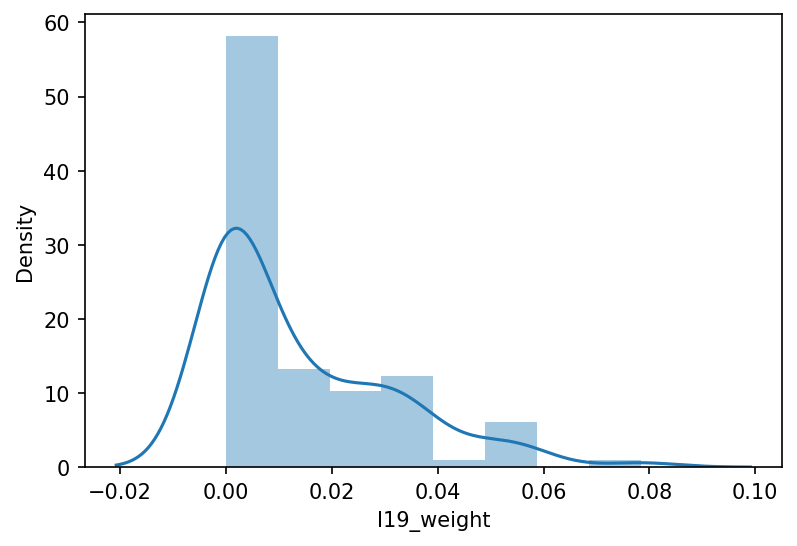

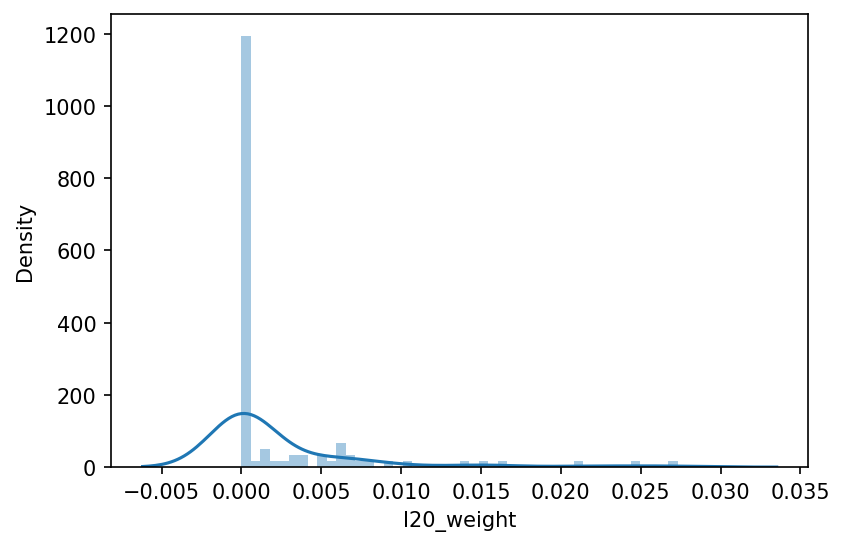

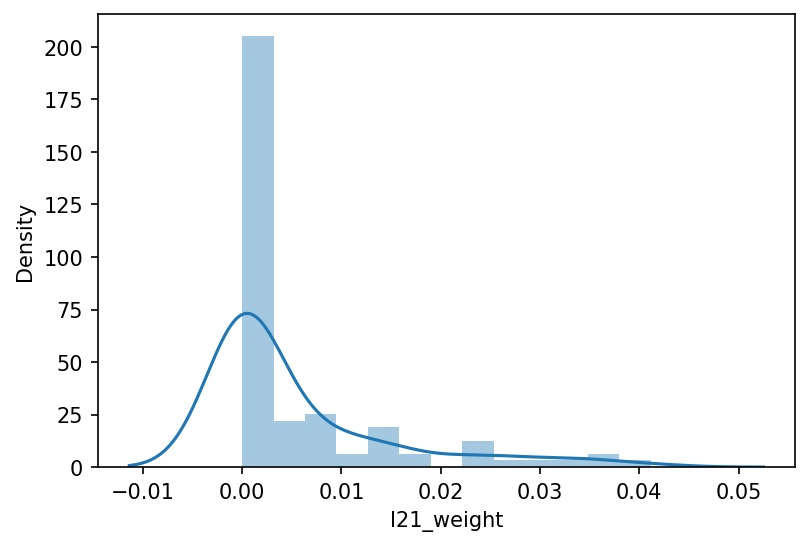

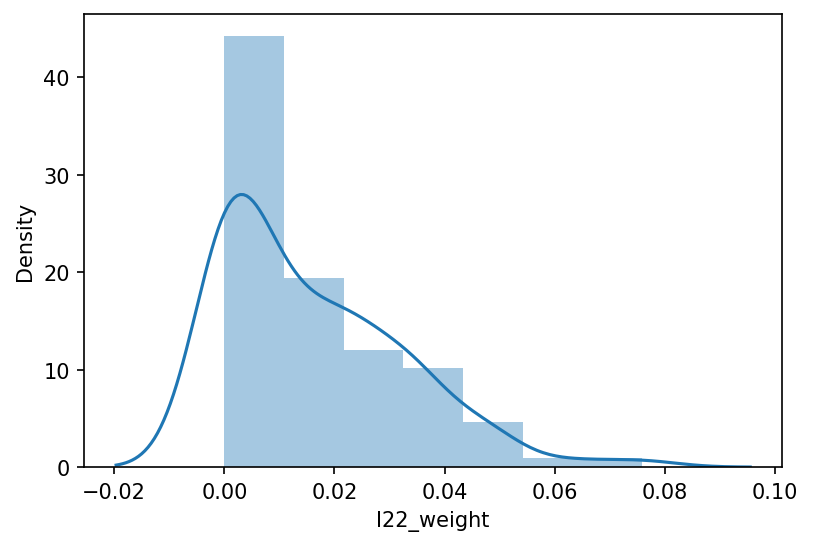

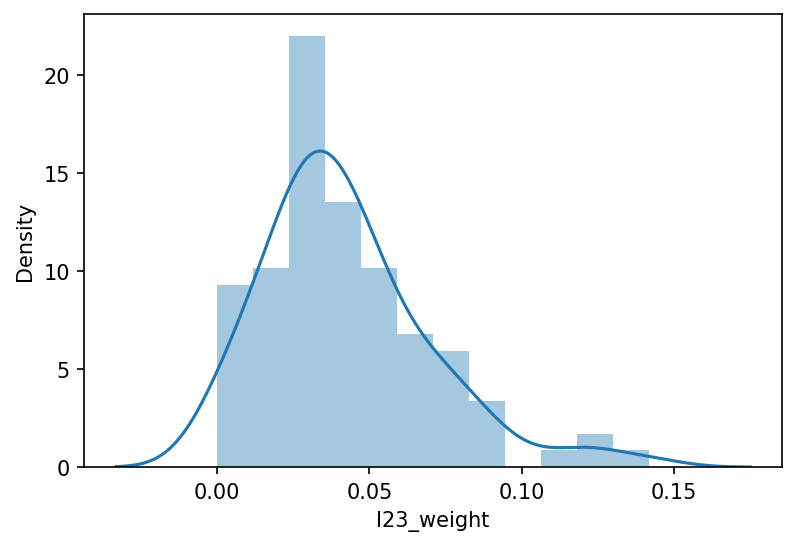

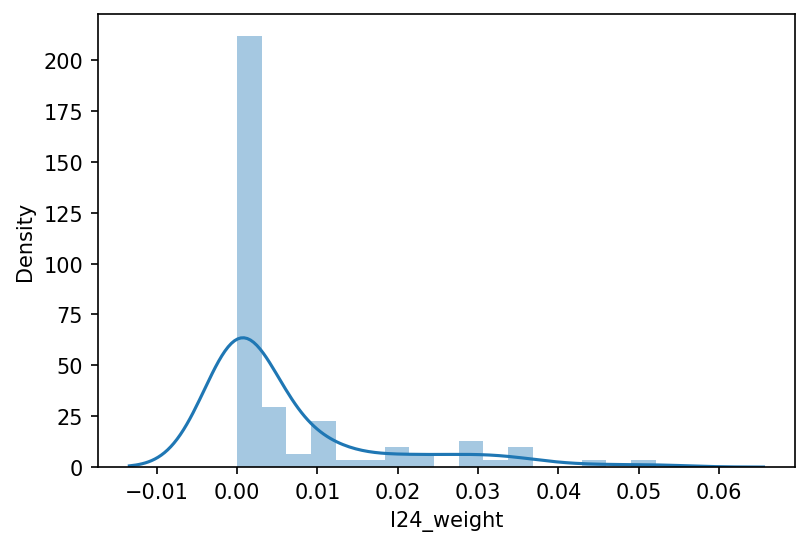

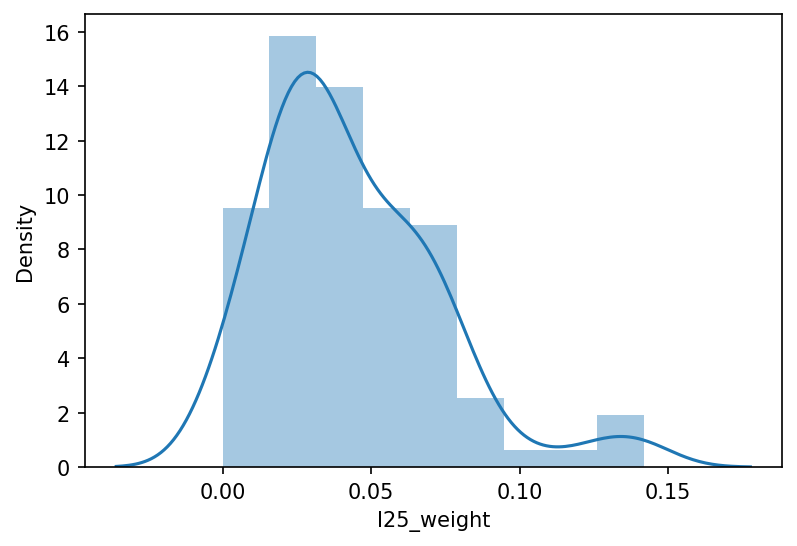

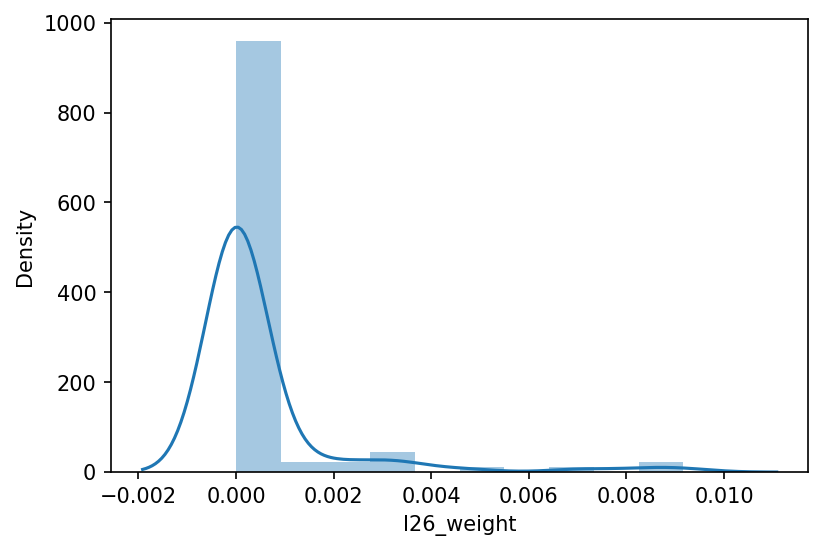

In [141]:
import seaborn as sns
from matplotlib import pyplot as plt
for x in range(1,27):
    plt.figure(dpi=150)
    sns.distplot(weights_df[f'I{x}_weight'])
    

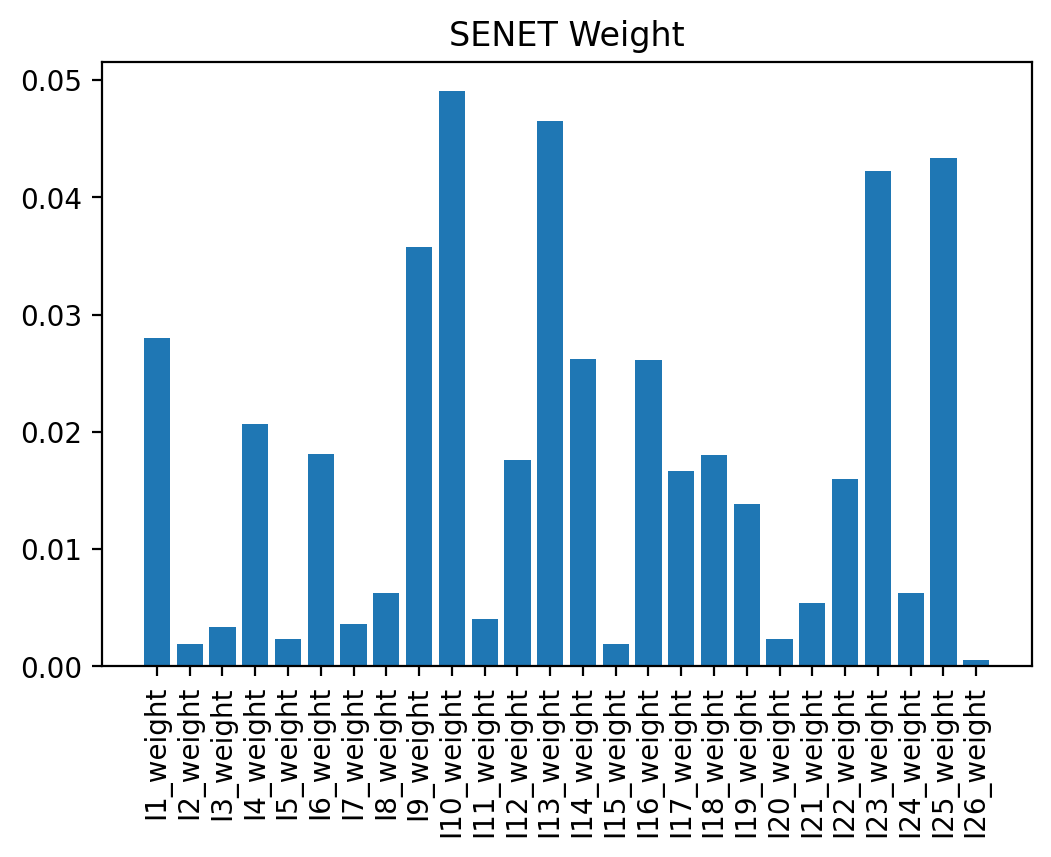

In [146]:
plt.figure(dpi=200)
plt.title('SENET Weight')
plt.bar(x=weights_df.mean().index, height=weights_df.mean().values)
plt.xticks(rotation=90)
plt.show()

In [142]:
weights_df.mean()

I1_weight     0.028057
I2_weight     0.001947
I3_weight     0.003374
I4_weight     0.020693
I5_weight     0.002298
I6_weight     0.018163
I7_weight     0.003593
I8_weight     0.006258
I9_weight     0.035766
I10_weight    0.049068
I11_weight    0.004038
I12_weight    0.017591
I13_weight    0.046511
I14_weight    0.026249
I15_weight    0.001892
I16_weight    0.026108
I17_weight    0.016639
I18_weight    0.018066
I19_weight    0.013813
I20_weight    0.002316
I21_weight    0.005412
I22_weight    0.015958
I23_weight    0.042282
I24_weight    0.006259
I25_weight    0.043376
I26_weight    0.000507
dtype: float32

In [143]:
weights_df.mean().index

Index(['I1_weight', 'I2_weight', 'I3_weight', 'I4_weight', 'I5_weight',
       'I6_weight', 'I7_weight', 'I8_weight', 'I9_weight', 'I10_weight',
       'I11_weight', 'I12_weight', 'I13_weight', 'I14_weight', 'I15_weight',
       'I16_weight', 'I17_weight', 'I18_weight', 'I19_weight', 'I20_weight',
       'I21_weight', 'I22_weight', 'I23_weight', 'I24_weight', 'I25_weight',
       'I26_weight'],
      dtype='object')

In [144]:
weights_df.mean().values

array([0.0280573 , 0.00194745, 0.00337434, 0.02069292, 0.00229834,
       0.01816285, 0.00359325, 0.00625764, 0.03576627, 0.04906775,
       0.00403808, 0.01759072, 0.04651104, 0.02624922, 0.00189151,
       0.02610762, 0.01663946, 0.01806592, 0.01381349, 0.00231554,
       0.0054115 , 0.01595803, 0.04228206, 0.00625854, 0.04337624,
       0.00050717], dtype=float32)

In [149]:
assert 1==2,'lalala'

AssertionError: lalala